In [1]:
%matplotlib inline
import random, pylab, math, random

# Introduction

In this week's lecture, we studied three algorithms for the simulation of hard disks in a box:
* Event-driven molecular dynamics
* Direct sampling
* Markov-chain sampling

In this homework, you will check that the statistical properties of these algorithms are all the same. You will then interpret their output, and finally, explicitly verify the equiprobability principle for hard disks in a box.

# A

In this section, we consider four disks in a square box of edge length 1, in a box without periodic boundary conditions. We set the density equal to $\eta = 0.18$, which corresponds to a disk radius $\sigma \simeq 0.1196$.

We consider a simple observable, the position $x$, as the $x$-coordinate of the center of a disk. We will compute its probability distribution, as the normed histogram of $x$-positions. This histogram is the same for all disks, so we can collect data for one disk or for all of them.

## A1

Compute the histogram of the $x$-positions for the direct-sampling Monte Carlo algorithm by modifying the algorithm implemented in the cell below. For the sake of students without prior knowledge of python, the corresponding code is given below . Simply run it to produce a histogram of the x-positions with 100 bins as output.

In [2]:
def direct_disks_box(N, sigma):
    overlap = True
    while overlap == True:
        L = [(random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))]
        for k in range(1, N):
            a = (random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))
            min_dist_sq = min(((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) for b in L) 
            if min_dist_sq < 4.0 * sigma ** 2: 
                overlap = True
                break
            else:
                overlap = False
                L.append(a)
    return L

N = 4
sigma = 0.1197
n_runs = 1000000
histo_data = []
for run in range(n_runs):
    pos = direct_disks_box(N, sigma)
    for k in range(N): histo_data.append(pos[k][0])

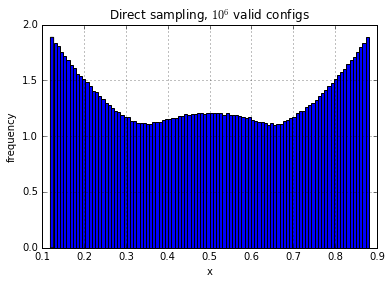

In [3]:
pylab.hist(histo_data, bins=100, normed=True)
pylab.xlabel('x')
pylab.ylabel('frequency')
pylab.title(r'Direct sampling, $10^6$ valid configs')
pylab.grid()
pylab.savefig('direct_disks_histo.png')
pylab.show()

## A2
### A2.1

Compute the histogram of the $x$-positions with 100 bins for the Markov-chain sampling algorithm, by
modifying the algorithm presented in class, and repeated in the cell below, in a manner similar to what was done in section A1. Set n_steps=2000000.

In [5]:
L = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
sigma = 0.15
sigma_sq = sigma ** 2
delta = 0.1
n_steps = 2000000
histo_data = []
for steps in range(n_steps):
    a = random.choice(L)
    b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
    min_dist = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in L if c != a)
    box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
    if not (box_cond or min_dist < 4.0 * sigma ** 2):
        a[:] = b
        histo_data.append(b[0])
print L

[[0.5125880951948425, 0.7110789997316647], [0.8181368890075097, 0.743454523726515], [0.47509546014006787, 0.3349450389831571], [0.7806756000462404, 0.36959381141681846]]


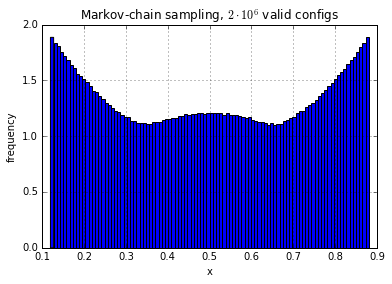

In [6]:
pylab.hist(histo_data, bins=100, normed=True)
pylab.xlabel('x')
pylab.ylabel('frequency')
pylab.title(r'Markov-chain sampling, $2 \cdot 10^6$ valid configs')
pylab.grid()
pylab.savefig('direct_disks_histo.png')
pylab.show()

### A2.2

State the **three mathematical conditions** that guarantee that the histogram for the Markov-chain
sampling algorithm agrees with the direct-sampling one. Furthermore, explain briefly whether
and why these three conditions are in fact satisfied by the four-disk system at density $\eta = 0.18$.

### Answer (A2.2)
1-st condition: Global balance

Global balance is satisfied if detailed balance is satisfied for pair of configurations $p_i \pi_{i,j}=p_j \pi_{j,i}$.
Transition between each two configurations can be divided into chain of steps where always one circle move, so that if detailed balance hold between each of steps balance should hold between states they conect.
For transition between two states by single circle move if both states are acceptable (circles do not overlap with each other or wall) probability of both states should be same $p_i=p_j$ and since move of circle is symetric with respect to reverse move also $\pi_{i,j} = \pi_{j,i}$, so that global balance should hold ... I hope.

2-nd condition : Ireducibility

Ireducibility means that configuration space is conected so that thare is at least one possible transition path between any two acceptable configurations. This should hold since density of system is low enough to enable cirlces fluctuate.

3-rd condition : Aperiodicity

System can not be periodic since move of each circle is always taken at random, so that there is way how to predict number of consecutive moves such that system always arive into same state.

## A3 Molecular dynamics

We now consider the event driven molecular dynamics algorithm. In sections (A3.1), (A3.2), and (A3.3), always
start from the algorithm provided in the cell below.

In [16]:
def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[0.21, 0.12], [0.71, 0.18], [-0.23, -0.79], [0.78, 0.1177]]
singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
sigma = 0.15
t = 0.0
n_events = 200000

histo_data_EDMD = []

for event in range(n_events):
    histo_data_EDMD.append(pos[0][0])
    wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
    next_event = min(wall_times + pair_times)
    t += next_event
    for k, l in singles: pos[k][l] += vel[k][l] * next_event 
    if min(wall_times) < min(pair_times):
        collision_disk, direction = singles[wall_times.index(next_event)]
        vel[collision_disk][direction] *= -1.0
    else: 
        a, b = pairs[pair_times.index(next_event)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        for k in range(2): 
            vel[a][k] += e_perp[k] * scal 
            vel[b][k] -= e_perp[k] * scal 
#    print 'event', event
#    print 'time', t
#    print 'pos', pos
#    print 'vel', vel

### A3.1.1

Compute the histogram for the $x$-positions with 100 bins analogously to what you did in sections (A1) and (A2.1),
but for the event-driven molecular dynamics algorithm. Collect the histogram from all particles and collision times (wall and pair collisions) and use a total number of events n_events=200000.

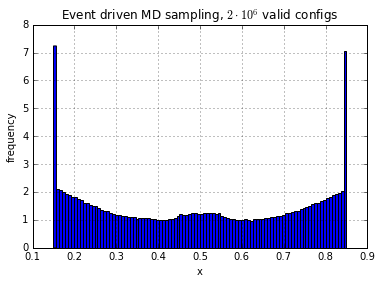

In [15]:
pylab.hist(histo_data_EDMD, bins=100, normed=True)
pylab.xlabel('x')
pylab.ylabel('frequency')
pylab.title(r'Event driven MD sampling, $2 \cdot 10^6$ valid configs')
pylab.grid()
pylab.savefig('direct_disks_histo_EDMD.png')
pylab.show()

### A3.1.2

This histogram differs from the ones in sections (A1) and (A2.1). Briefly explain its outstanding feature: the large
probability at $x = \sigma$ and $x = 1 - \sigma$.

Since samples are taken only when events (colisions) occure, higher densities of particles at walls might come from higher frequncy of particles coliding with walls so that leading to biase toward sampling positions at walls.

### A3.2

You may think that the difference between Monte Carlo and Molecular dynamics comes from taking into
account wall collisions. To test this idea, compute the histogram of the x-positions for the event-driven
molecular dynamics algorithm, but only at ALL PAIR COLLISION TIMES (that is, drop the wall collisions from (A3.1.1)) for n_events = 500000. 

In [17]:
def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[0.21, 0.12], [0.71, 0.18], [-0.23, -0.79], [0.78, 0.1177]]
singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
sigma = 0.15
t = 0.0
n_events = 500000

histo_data_EDMD_2 = []

for event in range(n_events):
    wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
    next_event = min(wall_times + pair_times)
    t += next_event
    for k, l in singles: pos[k][l] += vel[k][l] * next_event 
    if min(wall_times) < min(pair_times):
        collision_disk, direction = singles[wall_times.index(next_event)]
        vel[collision_disk][direction] *= -1.0
    else: 
        histo_data_EDMD_2.append(pos[0][0])
        a, b = pairs[pair_times.index(next_event)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        for k in range(2): 
            vel[a][k] += e_perp[k] * scal 
            vel[b][k] -= e_perp[k] * scal 
#    print 'event', event
#    print 'time', t
#    print 'pos', pos
#    print 'vel', vel

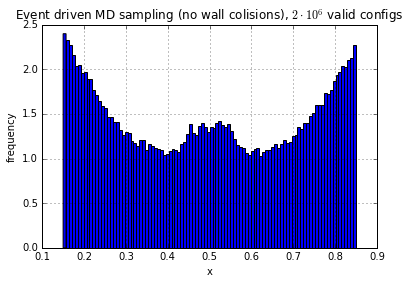

In [18]:
pylab.hist(histo_data_EDMD_2, bins=100, normed=True)
pylab.xlabel('x')
pylab.ylabel('frequency')
pylab.title(r'Event driven MD sampling (no wall colisions), $2 \cdot 10^6$ valid configs')
pylab.grid()
pylab.savefig('direct_disks_histo_EDMD_2.png')
pylab.show()

### A3.3.1
Finally, compute the histogram of the x-positions with 100 bins for the event-driven
molecular dynamics algorithm, where you take the $x$-positions at regular time intervals $t=0,1,2,3,\ldots$, using the
following code snippet, to be introduced after the line

"next_event = min(wall_times + pair_times)":

In [ ]:
next_event = min(wall_times + pair_times)
t_previous = t
for inter_times in range(int(t + 1), int(t + next_event + 1)):
    del_t = inter_times - t_previous
    for k, l in singles:
        pos[k][l] += vel[k][l] * del_t
    t_previous = inter_times
    for k in range(4):
        histo_data.append(pos[k][0])
t += next_event

Further, replace the line

In [ ]:
for k, l in singles: pos[k][l] += vel[k][l] * next_event

in the original algorithm by the line:

In [ ]:
for k, l in singles: pos[k][l] += vel[k][l] * (t - t_previous)

Set n_events=1000000. Compare the histogram with the ones you obtained in sections (A1) and (A2.1). Are
the probabilities the same?

In [24]:
def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[0.21, 0.12], [0.71, 0.18], [-0.23, -0.79], [0.78, 0.1177]]
singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
sigma = 0.15
t = 0.0
n_events = 1000000

histo_data_EDMD_3 = []

for event in range(n_events):
    wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
    next_event = min(wall_times + pair_times)
    t_previous = t
    for inter_times in range(int(t + 1), int(t + next_event + 1)):
        del_t = inter_times - t_previous
        for k, l in singles:
            pos[k][l] += vel[k][l] * del_t
        t_previous = inter_times
        for k in range(4):
            histo_data_EDMD_3.append(pos[0][0])
    t += next_event
    for k, l in singles: pos[k][l] += vel[k][l] * (t - t_previous)
    if min(wall_times) < min(pair_times):
        collision_disk, direction = singles[wall_times.index(next_event)]
        vel[collision_disk][direction] *= -1.0
    else: 
        a, b = pairs[pair_times.index(next_event)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        for k in range(2): 
            vel[a][k] += e_perp[k] * scal 
            vel[b][k] -= e_perp[k] * scal 
#    print 'event', event
#    print 'time', t
#    print 'pos', pos
#    print 'vel', vel

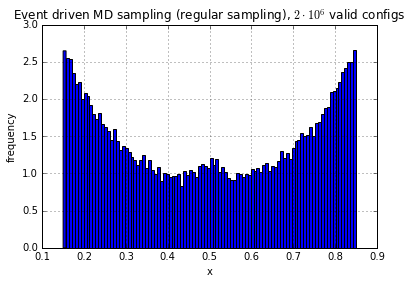

In [25]:
pylab.hist(histo_data_EDMD_3, bins=100, normed=True)
pylab.xlabel('x')
pylab.ylabel('frequency')
pylab.title(r'Event driven MD sampling (regular sampling), $2 \cdot 10^6$ valid configs')
pylab.grid()
pylab.savefig('direct_disks_histo_EDMD_3.png')
pylab.show()

### A3.3.2

The histogram you obtained in section (A3.3.1) should be (up to statistical fluctuations) identical to what
you obtained in sections (A1) and (A2.1). This is the consequence of the equivalence between Newton's deterministic dynamics and Boltzmann's statistical dynamics. Does this equivalence follow from the detailed balance condition respected by the algorithm?

### Answer (A3.3.2)

Hmmm not directly since algorithm might satisfy detailed balance criteria, but might not be ergodic. For example lets have two subsystems where transition between any pair of states, where both states are from different subsystems is equal to $0$.

# B

In this week's lecture, we have emphasized the importance of the equiprobability principle, which governs the statistical physics of hard disks and hard spheres, yet we have observed a manifestly non-uniform probability distribution of the $x$-positions (the equiprobability principle manifestly does not apply to $x$-positions).

## B1

To convince yourself that equiprobability **is** satisfied, in the eight-dimensional space of allowed
configurations of four-disk positions, consider the configuration (A) shown in the figures below. The
probability to sample this configuration **exactly** is of course zero, so we must put little boxes around this
configuration, as illustrated by the red squares.

![Configuration A](./Figures/A_fig.png "Configuration A")

![Configuration B](./Figures/B_fig.png "Configuration B")

![Configuration C](./Figures/C_fig.png "Configuration C")

Using small boxes $[x - 0.1, x + 0.1]$, modify the code given in section A1 to show that the probability to sample configurations A, B, and C are the same (within the numerical precision), with

A = [(0.25, 0.25), (0.25, 0.75), (0.75, 0.25), (0.75,0.75)]

B = [(0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75)]

C = [(0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70)]

In [64]:
def direct_disks_box(N, sigma):
    overlap = True
    while overlap == True:
        L = [(random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))]
        for k in range(1, N):
            a = (random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))
            min_dist_sq = min(((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) for b in L) 
            if min_dist_sq < 4.0 * sigma ** 2: 
                overlap = True
                break
            else:
                overlap = False
                L.append(a)
    return L

def aC(A,B):
    if (( B[0]+0.1 >= A[0] and B[0] <= A[0]+0.1 ) and ( B[1]+0.1 >= A[1] and B[1] <= A[1]+0.1 )):
        return True
    else:
        return False


N = 4
sigma = 0.0
n_runs = 1000000
histo_data = []
A = [(0.25, 0.25), (0.25, 0.75), (0.75, 0.25), (0.75,0.75)]

B = [(0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75)]

C = [(0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70)]

hit_A=0.0
hit_B=0.0
hit_C=0.0

for run in range(n_runs):
    pos = direct_disks_box(N, sigma)
    if   (aC(A[0],pos[0]) and aC(A[1],pos[1]) and aC(A[2],pos[2]) and aC(A[3],pos[3])):
        hit_A+=1.0;
    elif (aC(B[0],pos[0]) and aC(B[1],pos[1]) and aC(B[2],pos[2]) and aC(B[3],pos[3])):
        hit_B+=1.0;
    elif (aC(C[0],pos[0]) and aC(C[1],pos[1]) and aC(C[2],pos[2]) and aC(C[3],pos[3])):
        hit_C+=1.0;        

print "Sigma = 0.0"        
print "Configuration A frequency: %f/%f"%(hit_A,n_runs)
print "Configuration B frequency: %f/%f"%(hit_B,n_runs)
print "Configuration C frequency: %f/%f"%(hit_C,n_runs)

sigma = 0.1
for run in range(n_runs):
    pos = direct_disks_box(N, sigma)
    if   (aC(A[0],pos[0]) and aC(A[1],pos[1]) and aC(A[2],pos[2]) and aC(A[3],pos[3])):
        hit_A+=1.0;
    elif (aC(B[0],pos[0]) and aC(B[1],pos[1]) and aC(B[2],pos[2]) and aC(B[3],pos[3])):
        hit_B+=1.0;
    elif (aC(C[0],pos[0]) and aC(C[1],pos[1]) and aC(C[2],pos[2]) and aC(C[3],pos[3])):
        hit_C+=1.0;        

print "Sigma = 0.1"        
print "Configuration A frequency: %f/%f"%(hit_A,n_runs)
print "Configuration B frequency: %f/%f"%(hit_B,n_runs)
print "Configuration C frequency: %f/%f"%(hit_C,n_runs)

Sigma = 0.0
Configuration A frequency: 4.000000/1000000.000000
Configuration B frequency: 2.000000/1000000.000000
Configuration C frequency: 4.000000/1000000.000000
Sigma = 0.1
Configuration A frequency: 44.000000/1000000.000000
Configuration B frequency: 33.000000/1000000.000000
Configuration C frequency: 39.000000/1000000.000000


Run your program for a disk radius $\sigma=0$  and for $\sigma=0.1$. In two sentences,
explain what this program does and write down the obtained frequencies for configurations A, B, and C,
with four digits (e.g. 0.003) and provide a short explanation.

Program is rather simple it use generator of random acceptable configuration and then compare one of three sampled configurations to obtained random configuration. If random configuration agree with any of sampled configuration count one hit for that configuration (I assume circles being distinguishible).

Considering size of all possible configurations and size of subset of sampled confugurations number of hits are small especialy for $\sigma=0.0$ since whole configuration space is larger then in case of $\sigma=0.1$ where number of all possible configuration decrease since part of space is excluded due to size of circles.

## B2
Provide an analytical expression for these probabilities, for both cases $\sigma=0$ and for $\sigma=0.1$, and check it
against the results of section (B1). Note that for $\sigma=0.1$, you need to know the acceptance ratio of the algorithm, and you need to modify your program to obtain it. Explain your analytical formula both for $\sigma=0$ and for $\sigma=0.1$ and compare it to your results from part (B1).

For $\sigma=0$ probability of obtaining particular configuration is given by product of areas in which each point could be inserted to satisfy particular configuration, since these areas are not dependent on particular position in box each sampled configuration are same probbable and probability is given as $P_{A}=P_{B}=P_{C}=\frac{(0.1\cdot 0.1)^4}{1^8}=0.00000256$, where denominator is size (volume) of whole configuration space.